In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from matplotlib.colors import LogNorm

from numpy.fft import fftshift, fftfreq, fft
from scipy import signal

from itertools import combinations_with_replacement

In [2]:
def get_vis_data(files,jd_range):
    
    uvd = UVData()
    if len(files)>1:
        uvd.read(files,axis='freq',time_range=jd_range)
    else:
        uvd.read(files,time_range=jd_range)

    ants = uvd.get_ants()
    pols = uvd.get_pols()
    Nbl = uvd.Nbls
    freqs = (uvd.freq_array)[0]
    lsts = ((uvd.lst_array).reshape(-1,Nbl)*180./(15.*np.pi))[:,0]
    idx = np.argsort(lsts)
    uvw = (uvd.uvw_array).reshape(-1,Nbl,3)
    bls = np.sqrt(np.sum(uvw[0]**2,axis=1))
    bls = bls[bls!=0.]
  
    autos = np.zeros((3,2,len(lsts),len(freqs)),dtype=np.complex)
    cross = np.zeros((3,2,len(lsts),len(freqs)),dtype=np.complex)

    cross_IDs = []

    i = 0
    j = 0

    for ant1, ant2 in combinations_with_replacement(ants, 2):
        if ant1==ant2:
            autos[i,0] = uvd.get_data([ant1,ant2,'xx'])
            autos[i,1] = uvd.get_data([ant1,ant2,'yy'])
            i+=1
        else:
            cross_IDs.append([ant1,ant2])
            cross[j,0] = uvd.get_data([ant1,ant2,'xx'])
            cross[j,1] = uvd.get_data([ant1,ant2,'yy'])
            j+=1
    return autos[:,:,idx,:], cross[:,:,idx,:], cross_IDs, freqs, lsts[idx], ants, bls, pols

def calculate_delayspec(autos, cross, freqs):
    
    window = signal.blackmanharris(len(freqs))[np.newaxis,np.newaxis,np.newaxis,:]
    
    F_autos = fftshift(fft(autos*window,axis=3),axes=3)
    F_cross = fftshift(fft(cross*window,axis=3),axes=3)
    
    tau = fftshift(fftfreq(len(freqs),d=freqs[1]-freqs[0]))

    return F_autos, F_cross, tau

def dB(x):
    return 10*np.log10(x/np.amax(x))


def colorbar_plotter(fig,ax,im,label):
        
    pos = ax.get_position()
    cbarax = fig.add_axes([pos.x0 + pos.width+0.01, pos.y0, 0.008, pos.height])

    cbar = fig.colorbar(im,cax=cbarax)

    cbar.ax.tick_params(labelsize=16) 
    cbar.ax.set_ylabel(label,fontsize=16)
    
    return cbar


def Ra_Dec_to_Az_El(RA,Dec,lst):
    
    lat = -30.721527777777847*np.pi/180.
    
    HA = (lst*15.*np.pi/180. - RA)
    
    sin_El = np.sin(Dec)*np.sin(lat)+np.cos(Dec)*np.cos(lat)*np.cos(HA)
    El = np.arcsin(sin_El)
    
    cos_A = (np.sin(Dec) - np.sin(El)*np.sin(lat))/(np.cos(El)*np.cos(lat))
    sin_A = -np.sin(HA)*np.cos(Dec)/np.cos(El)
    Az = np.arctan2(sin_A,cos_A)
  
    return Az, 0.5*np.pi - El

def nearest_idx(data,val):
    return np.abs(data - val).argmin()

def calculate_delayrate_spec(autos, cross, lsts):
    
    window = signal.blackmanharris(len(lsts))[np.newaxis,np.newaxis,:,np.newaxis]

    F_autos = fftshift(fft(autos*window,axis=2),axes=2)
    F_cross = fftshift(fft(cross*window,axis=2),axes=2)
    
    tau = fftshift(fftfreq(len(lsts),d=lsts[1]-lsts[0]))

    return F_autos, F_cross, tau/3600.

In [3]:
def delayspec_plotter(spectrum,tau_grid,lst_grid,bls,title_str, supertitle):
    fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(22,12))
    fig.subplots_adjust(wspace=0.1,hspace=0.15)
    fig.suptitle(supertitle,fontsize=18)

    if bls is not None:
        t_horizon = 1.e9*bls/3.e8
    
    for i in range(2):
        for j in range(3):        
            axim = axs[i,j].pcolormesh(tau_grid,lst_grid,dB(abs(spectrum[j,i])),vmin=-100,vmax=0,cmap='Spectral_r')
            if bls is not None:
                axs[i,j].axvline(t_horizon[j],c='k',ls='--',lw=2)
                axs[i,j].axvline(-1.*t_horizon[j],c='k',ls='--',lw=2)
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            axs[i,j].set_xlim(-1500.,1500.)
            if i==0:
                axs[i,j].set_title(title_str[j],fontsize=16)
                if j==0:
                    axs[i,j].set_ylabel('E-pol\n'+r'LST$\,[$h$]$',fontsize=16)
            else:
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)        
                if j==0:
                    axs[i,j].set_ylabel('N-pol\n'+r'LST$\,[$h$]$',fontsize=16)
        
        if j==2:
            colorbar_plotter(fig,axs[i,j],axim,r'dB')
            

def delayrate_spec_plotter(spectrum,tau_grid,ft_grid,bls,title_str, supertitle):
    fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(22,12))
    fig.subplots_adjust(wspace=0.1,hspace=0.15)
    fig.suptitle(supertitle,fontsize=18)
    
    if bls is not None:
        t_horizon = 1.e9*bls/3.e8
    
    for i in range(2):
        for j in range(3):        
            axim = axs[i,j].pcolormesh(tau_grid,ft_grid/1.e-3,dB(abs(spectrum[j,i])),vmin=-100,vmax=0,cmap='Spectral_r')
            if bls is not None:
                axs[i,j].axvline(t_horizon[j],c='k',ls='--',lw=2)
                axs[i,j].axvline(-1.*t_horizon[j],c='k',ls='--',lw=2)
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            axs[i,j].set_xlim(-1000.,1000.)
            axs[i,j].set_ylim(-5.,5.)
            if i==0:
                axs[i,j].set_title(title_str[j],fontsize=16)
                if j==0:
                    axs[i,j].set_ylabel('E-pol\n'+r'Fringe rate$\,[$mHz$]$',fontsize=16)
            else:
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)        
                if j==0:
                    axs[i,j].set_ylabel('N-pol\n'+r'Fringe rate$\,[$mHz$]$',fontsize=16)
        
        if j==2:
            colorbar_plotter(fig,axs[i,j],axim,r'dB')
            


Text(0, 0.5, 'y-direction--> $[$m$]$')

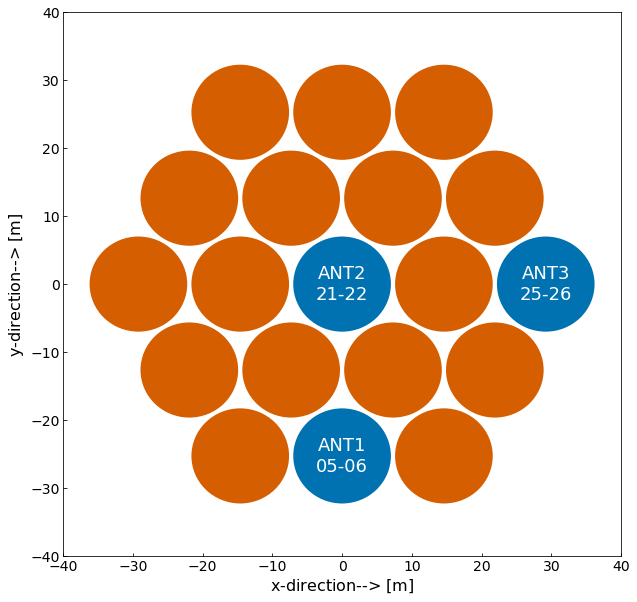

In [4]:
ant_pos = np.loadtxt('HERA_positions/antenna_positions_19.dat')[:,:-1]
ant_id = [9,11,17]

ant_pos = ant_pos -  ant_pos[9,:][np.newaxis,:]

ant_name = ['ANT2\n21-22','ANT3\n25-26','ANT1\n05-06']
colors = ["#D55E00", "#0072B2"]

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
j=0
for i in range(ant_pos.shape[0]):
    if (i in ant_id):
        ant = plt.Circle((ant_pos[i,0],ant_pos[i,1]),7.,facecolor=colors[1])
        plt.text(ant_pos[i,0],ant_pos[i,1],ant_name[j],horizontalalignment='center',
                 verticalalignment='center',multialignment='center',fontsize=18,color='white') 
        
        j+=1
    else:
        ant = plt.Circle((ant_pos[i,0],ant_pos[i,1]),7.,facecolor=colors[0])

    axs.add_artist(ant)

axs.set_xlim(-40.,40.)
axs.set_ylim(-40.,40.)

axs.tick_params(axis='both',direction='in',which='both',labelsize=14)

axs.set_xlabel(r'x-direction--> $[$m$]$',fontsize=16)
axs.set_ylabel(r'y-direction--> $[$m$]$',fontsize=16)

In [5]:
#Read visibility data and calculate delay spectra
JDstart = 2458116.24485307
JDend = JDstart + (23.92/24.)

files_nocc  = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_no-cc-3ant_1src_spw1_820ch-24h.uvh5'))
files_cc    = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_cc-3ant_1src_spw*_410ch-24hr_pos-corrected.uvh5'))
files_cc_1b = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_cc-singlebeam-3ant_1src_spw1_820ch-24h.uvh5'))

autos_nocc, cross_nocc, cross_IDs, freqs, lsts, ants, bls, pols = get_vis_data(files_nocc,[JDstart,JDend])
autos_cc, cross_cc, _, _, _, _, _, _ = get_vis_data(files_cc,[JDstart,JDend])
autos_cc_1b, cross_cc_1b, _, _, _, _, _, _ = get_vis_data(files_cc_1b,[JDstart,JDend])

idx = np.where(autos_nocc[0,0,:,0]!=0.)[0]
lst = lsts[idx]

F_autos_nocc, F_cross_nocc, tau = calculate_delayspec(autos_nocc[:,:,idx,:], cross_nocc[:,:,idx,:], freqs)
F_autos_cc, F_cross_cc, _ = calculate_delayspec(autos_cc[:,:,idx,:], cross_cc[:,:,idx,:], freqs)
F_autos_cc_1b, F_cross_cc_1b, _ = calculate_delayspec(autos_cc_1b[:,:,idx,:], cross_cc_1b[:,:,idx,:], freqs)

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


In [6]:
t_g, lst_g = np.meshgrid(tau*1.e9,lst)

autos_str = [r'ANT1','ANT2',r'ANT3']
cross_str = [r'ANT1-ANT2','ANT1-ANT3',r'ANT2-ANT3']

Text(0.5, 1.0, 'N-pol')

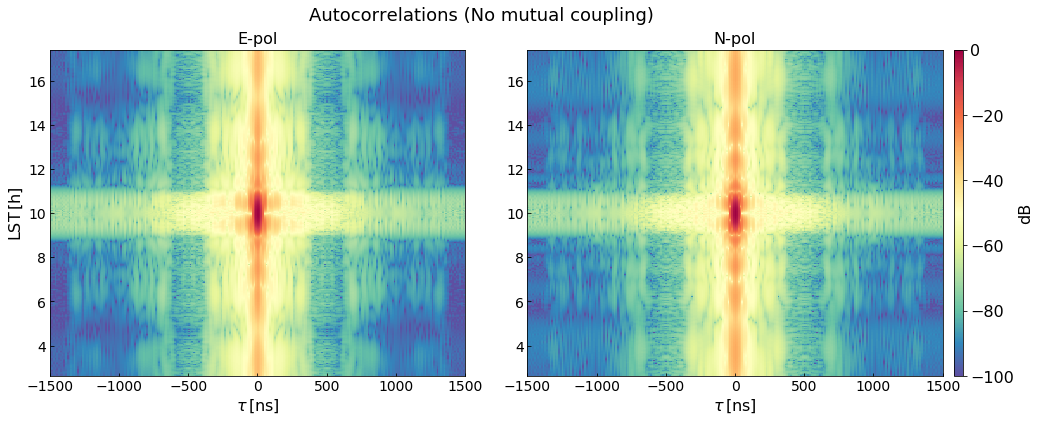

In [7]:
fig1, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
fig1.subplots_adjust(wspace=0.15)
fig1.suptitle(r'Autocorrelations (No mutual coupling)',fontsize=18)

for i in range(2):        
    axim = axs[i].pcolormesh(t_g,lst_g,dB(abs(F_autos_nocc[0,i])),vmin=-100,vmax=0,cmap='Spectral_r')    
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=14)
    axs[i].set_xlim(-1500.,1500.)
    axs[i].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)     
    
    if i==0:
        axs[i].set_ylabel(r'LST$\,[$h$]$',fontsize=16)
    else:
        colorbar_plotter(fig1,axs[i],axim,r'dB')
         
axs[0].set_title(r'E-pol',fontsize=16)
axs[1].set_title(r'N-pol',fontsize=16)

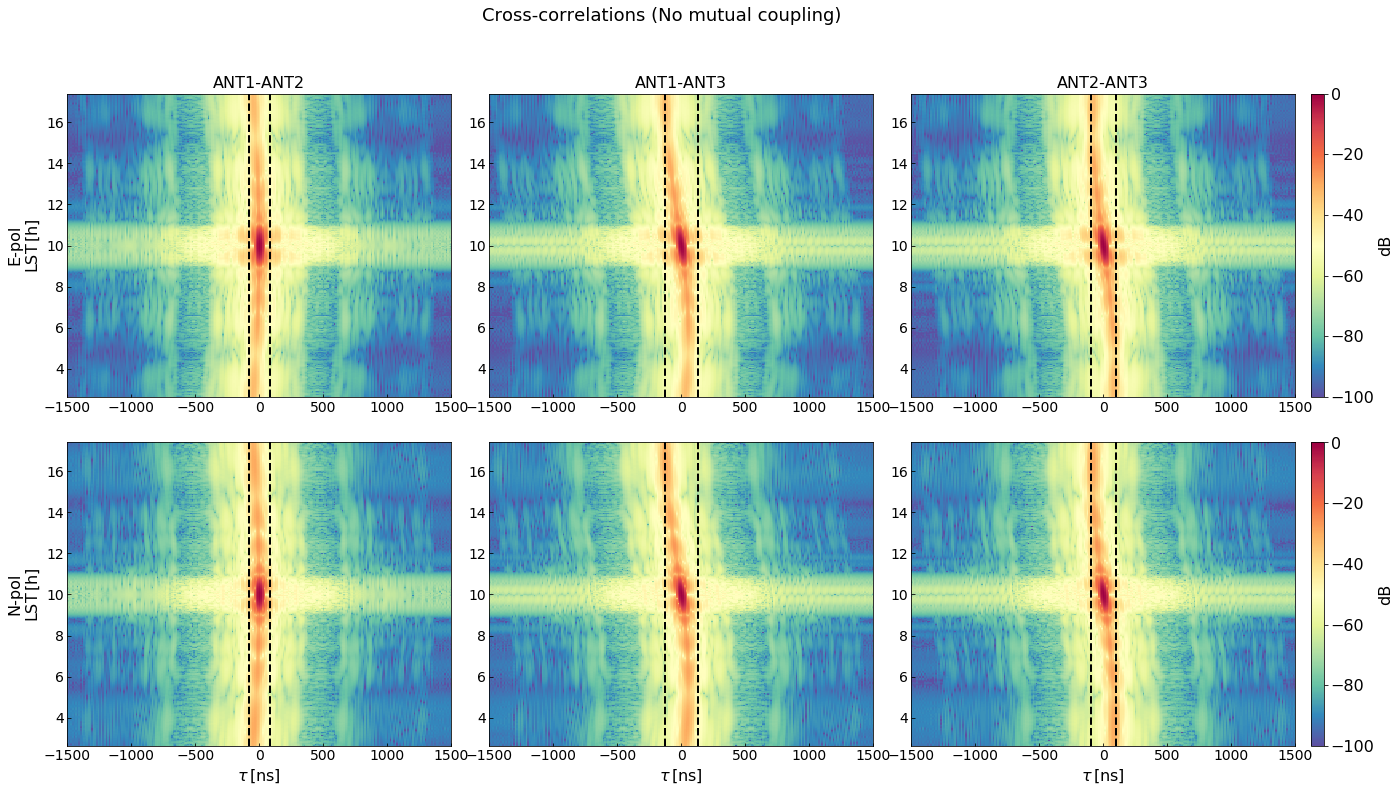

In [8]:
delayspec_plotter(F_cross_nocc,t_g,lst_g,bls,cross_str,r'Cross-correlations (No mutual coupling)')

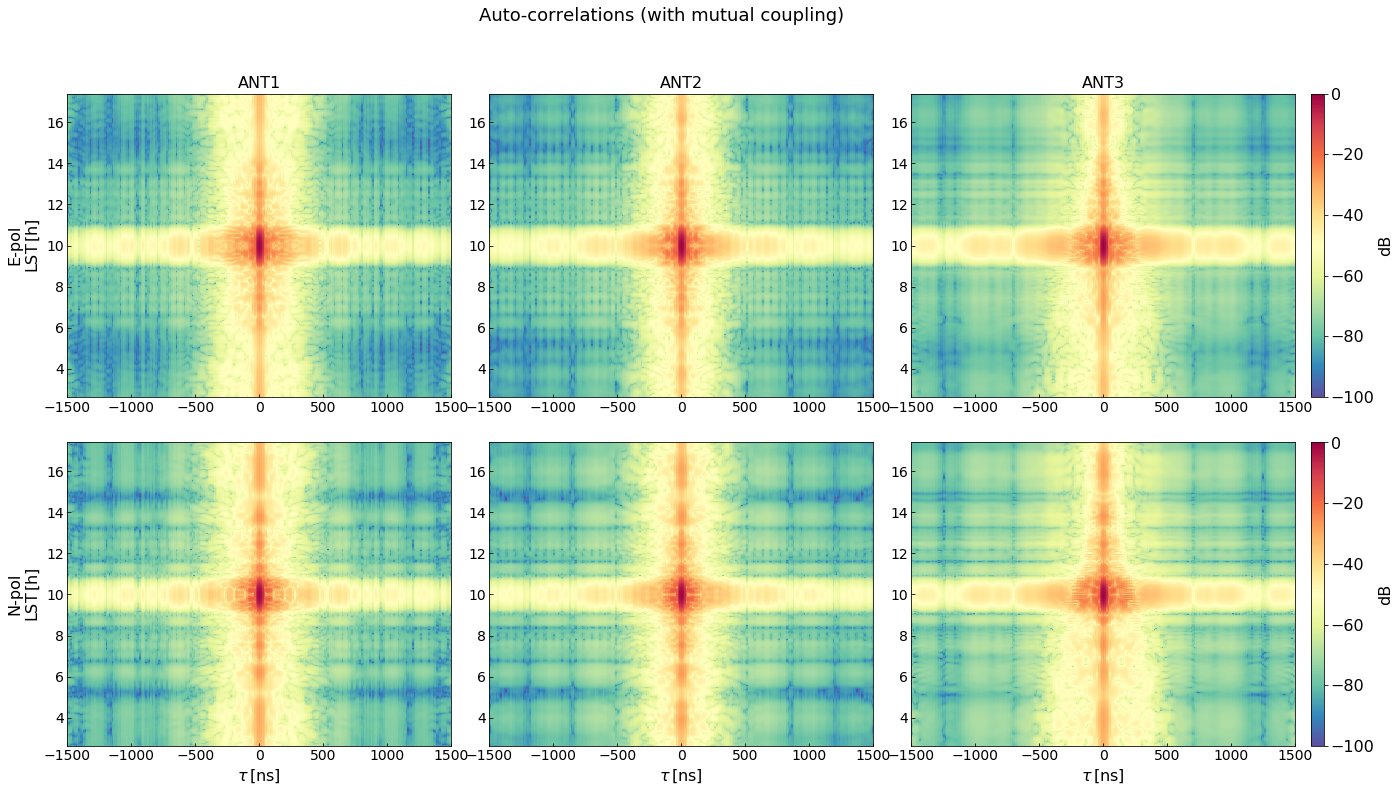

In [9]:
delayspec_plotter(F_autos_cc,t_g,lst_g,None,autos_str,r'Auto-correlations (with mutual coupling)')

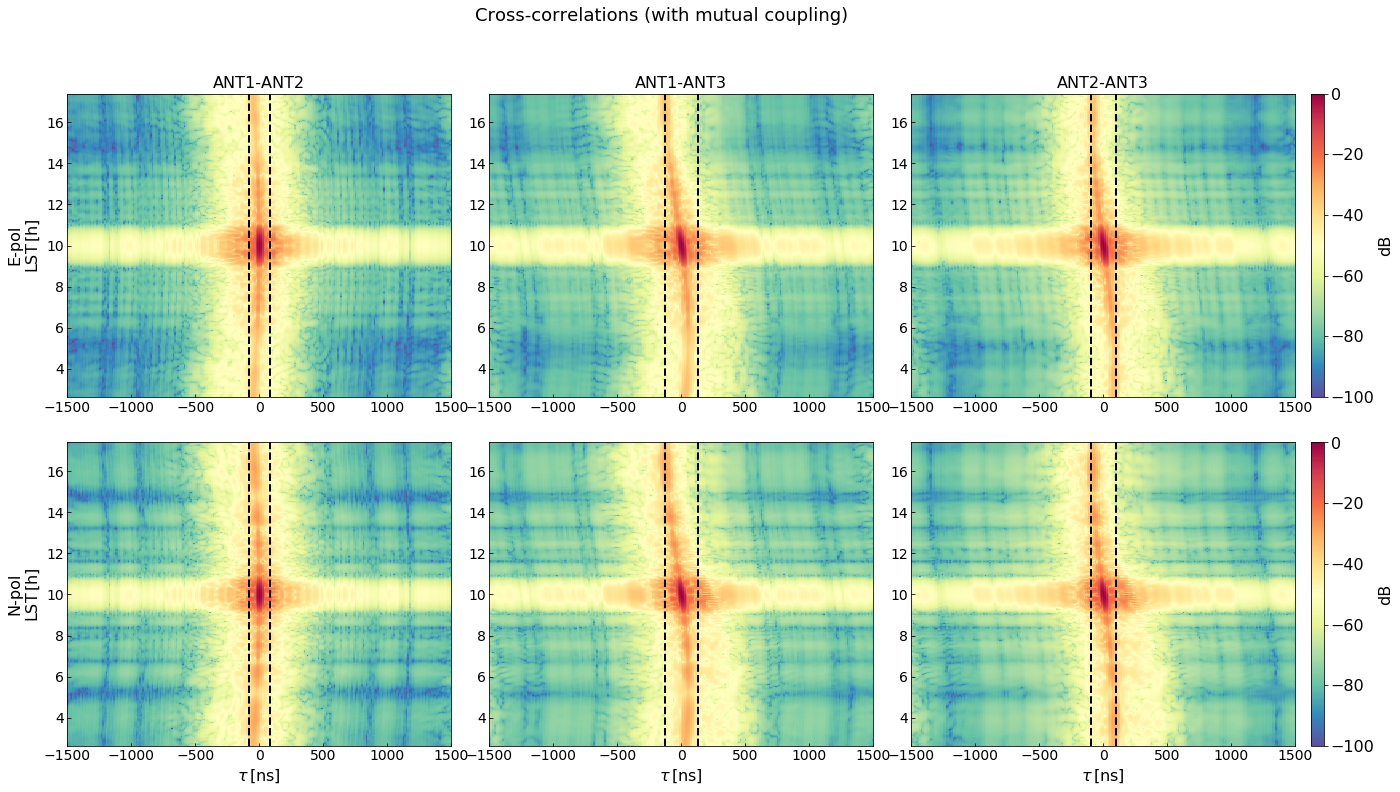

In [10]:
delayspec_plotter(F_cross_cc,t_g,lst_g,bls,cross_str,r'Cross-correlations (with mutual coupling)')

Text(0.5, 1.0, 'N-pol')

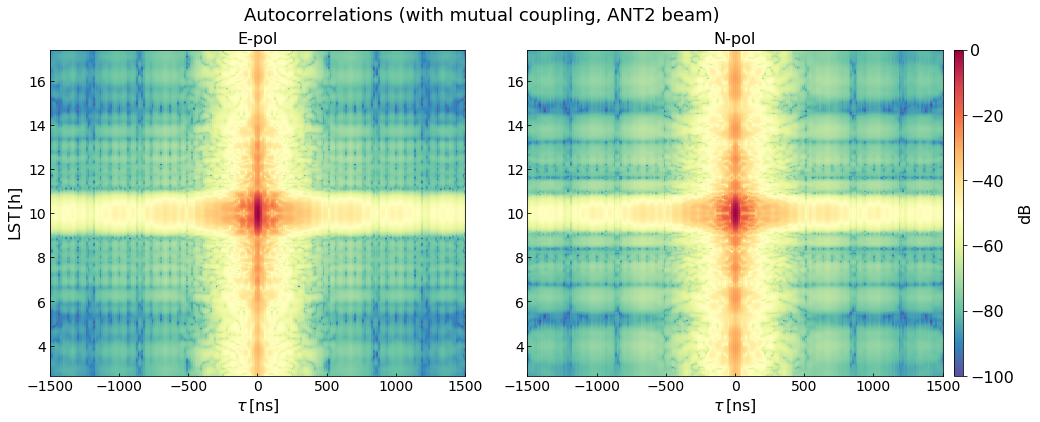

In [11]:
fig2, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
fig2.subplots_adjust(wspace=0.15)
fig2.suptitle(r'Autocorrelations (with mutual coupling, ANT2 beam)',fontsize=18)

for i in range(2):        
    axim = axs[i].pcolormesh(t_g,lst_g,dB(abs(F_autos_cc_1b[0,i])),vmin=-100,vmax=0,cmap='Spectral_r')    
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=14)
    axs[i].set_xlim(-1500.,1500.)
    axs[i].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)     
    
    if i==0:
        axs[i].set_ylabel(r'LST$\,[$h$]$',fontsize=16)
    else:
        colorbar_plotter(fig2,axs[i],axim,r'dB')
         
axs[0].set_title(r'E-pol',fontsize=16)
axs[1].set_title(r'N-pol',fontsize=16)

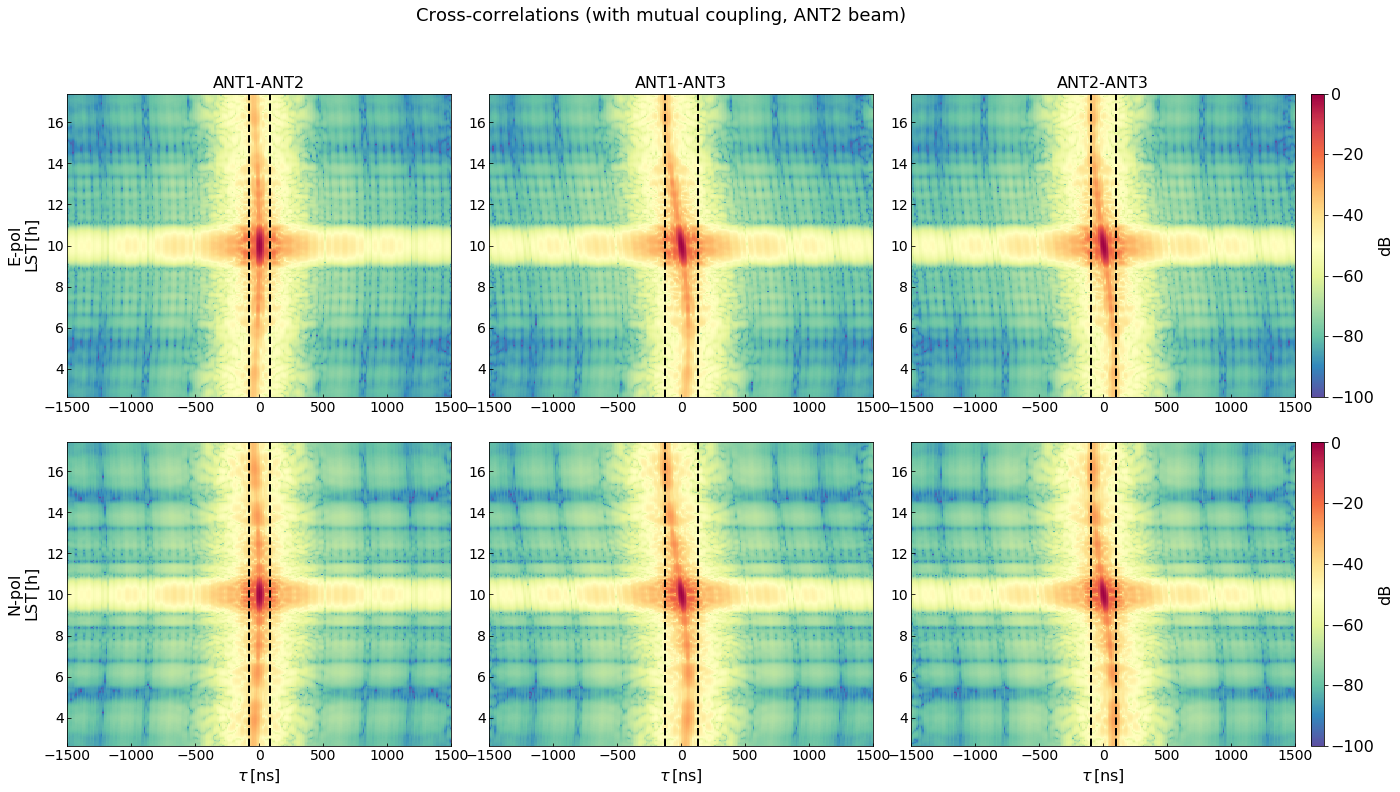

In [12]:
delayspec_plotter(F_cross_cc_1b,t_g,lst_g,bls,cross_str,r'Cross-correlations (with mutual coupling, ANT2 beam)')

In [13]:
RA = 150.*np.pi/180.
DEC = -30.7224*np.pi/180.
lst_slice = np.array([4.,10.,16.])
az, za = Ra_Dec_to_Az_El(RA,DEC,lst_slice)

lst_idx = [nearest_idx(lst,lst_slice[0]),
           nearest_idx(lst,lst_slice[1]),
           nearest_idx(lst,lst_slice[2])]

titles = [r'LST = %.2f'%(lst_slice[0]), r'LST = %.2f'%(lst_slice[1]), r'LST = %.2f'%(lst_slice[2])]

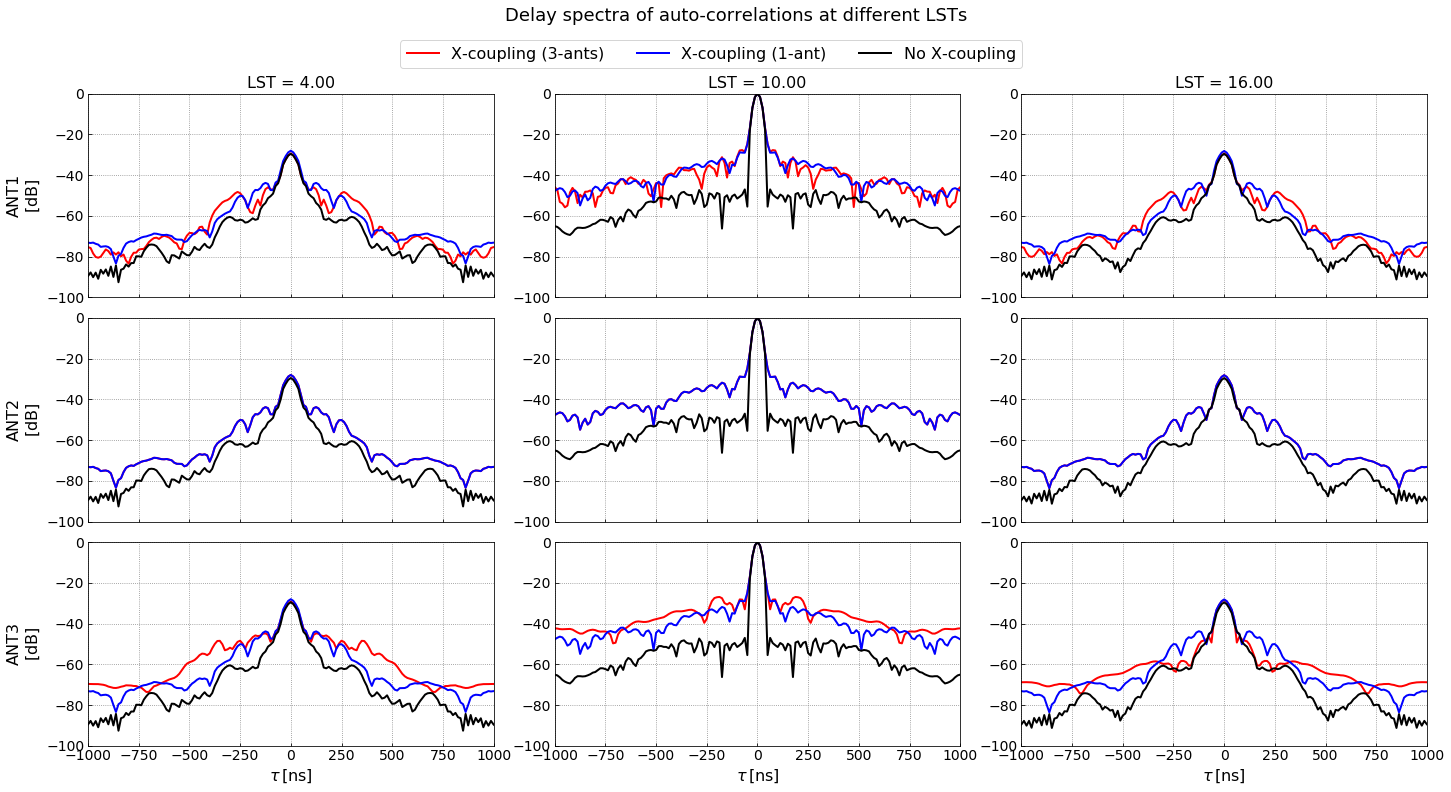

In [14]:
fig3, axs = plt.subplots(nrows=3,ncols=3,figsize=(24,12))
fig3.subplots_adjust(wspace=0.15,hspace=0.1)
fig3.suptitle(r'Delay spectra of auto-correlations at different LSTs',fontsize=18)

t_horizon = 1.e9*bls/3.e8

for i in range(3):
    for j in range(3):
        
        axs[i,j].plot(tau*1.e9,dB(abs(F_autos_cc[i,1]))[lst_idx[j],:],c='r',lw=2,label=r'X-coupling (3-ants)')
        axs[i,j].plot(tau*1.e9,dB(abs(F_autos_cc_1b[i,1]))[lst_idx[j],:],c='b',lw=2,label=r'X-coupling (1-ant)')
        axs[i,j].plot(tau*1.e9,dB(abs(F_autos_nocc[i,1]))[lst_idx[j],:],c='k',lw=2,label=r'No X-coupling') 

        axs[i,j].set_xlim(-1000.,1000.)
                
        if i==2:
            axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)  
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
        elif i==0:
            axs[i,j].set_title(titles[j],fontsize=16)
            axs[i,j].tick_params(axis='both',which='both',direction='in',labelbottom=False,labelsize=14)
        else:
            axs[i,j].tick_params(axis='both',which='both',direction='in',labelbottom=False,labelsize=14)
            
        if j==0:
            axs[i,j].set_ylabel(autos_str[i]+'\n'+r'$[$dB$]$',fontsize=16)
            
        axs[i,j].set_ylim(-100,0)

        axs[i,j].grid(lw=0.8,ls=':',c='gray')
        
handles, labels = axs[0,1].get_legend_handles_labels()
axs[0,1].legend(handles,labels,fontsize=16,ncol=3,loc='upper left',bbox_to_anchor=(-0.4,1.3))


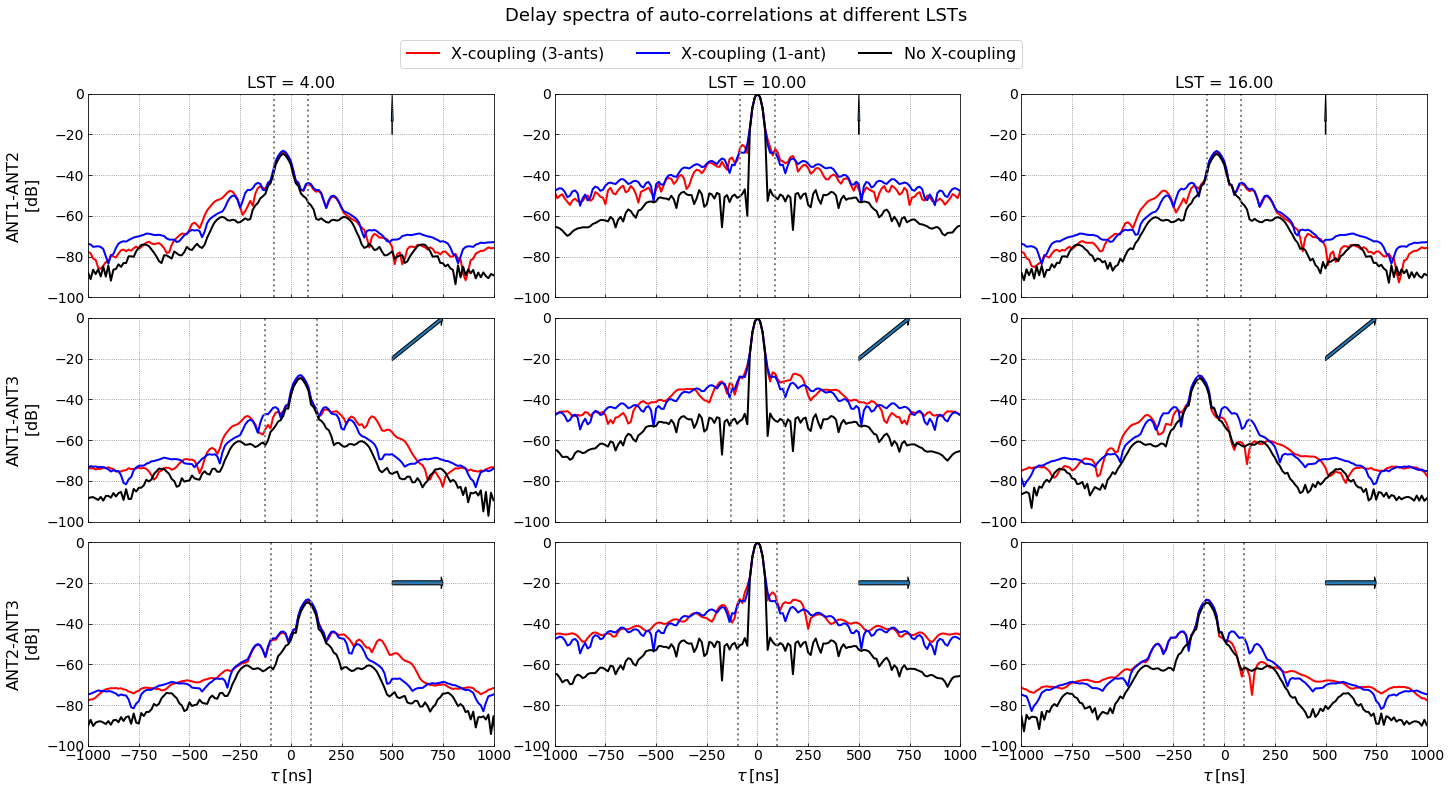

In [15]:
arrows = [500.,-20.]
dx = [0.,250.,250.]
dy = [20.,20.,0.]
aw = [3,2,2]

fig4, axs = plt.subplots(nrows=3,ncols=3,figsize=(24,12))
fig4.subplots_adjust(wspace=0.15,hspace=0.1)
fig4.suptitle(r'Delay spectra of auto-correlations at different LSTs',fontsize=18)

t_horizon = 1.e9*bls/3.e8

for i in range(3):
    for j in range(3):
        
        axs[i,j].plot(tau*1.e9,dB(abs(F_cross_cc[i,1]))[lst_idx[j],:],c='r',lw=2,label=r'X-coupling (3-ants)')
        axs[i,j].plot(tau*1.e9,dB(abs(F_cross_cc_1b[i,1]))[lst_idx[j],:],c='b',lw=2,label=r'X-coupling (1-ant)')
        axs[i,j].plot(tau*1.e9,dB(abs(F_cross_nocc[i,1]))[lst_idx[j],:],c='k',lw=2,label=r'No X-coupling') 

        axs[i,j].set_xlim(-1000.,1000.)
        
        axs[i,j].axvline(t_horizon[i],c='gray',ls=':',lw=2)
        axs[i,j].axvline(-1.*t_horizon[i],c='gray',ls=':',lw=2)
        axs[i,j].arrow(arrows[0],arrows[1],dx=dx[i],dy=dy[i],width=aw[i],length_includes_head=True)
        
        if i==2:
            axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)  
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
        elif i==0:
            axs[i,j].set_title(titles[j],fontsize=16)
            axs[i,j].tick_params(axis='both',which='both',direction='in',labelbottom=False,labelsize=14)
        else:
            axs[i,j].tick_params(axis='both',which='both',direction='in',labelbottom=False,labelsize=14)
            
        if j==0:
            axs[i,j].set_ylabel(cross_str[i]+'\n'+r'$[$dB$]$',fontsize=16)
            
        axs[i,j].set_ylim(-100,0)

        axs[i,j].grid(lw=0.8,ls=':',c='gray')
        
handles, labels = axs[0,1].get_legend_handles_labels()
axs[0,1].legend(handles,labels,fontsize=16,ncol=3,loc='upper left',bbox_to_anchor=(-0.4,1.3))


In [16]:
FF_autos_nocc, FF_cross_nocc, ft = calculate_delayrate_spec(F_autos_nocc, F_cross_nocc, lst)
FF_autos_cc, FF_cross_cc, ft = calculate_delayrate_spec(F_autos_cc, F_cross_cc, lst)
FF_autos_cc_1b, FF_cross_cc_1b, ft = calculate_delayrate_spec(F_autos_cc_1b, F_cross_cc_1b, lst)

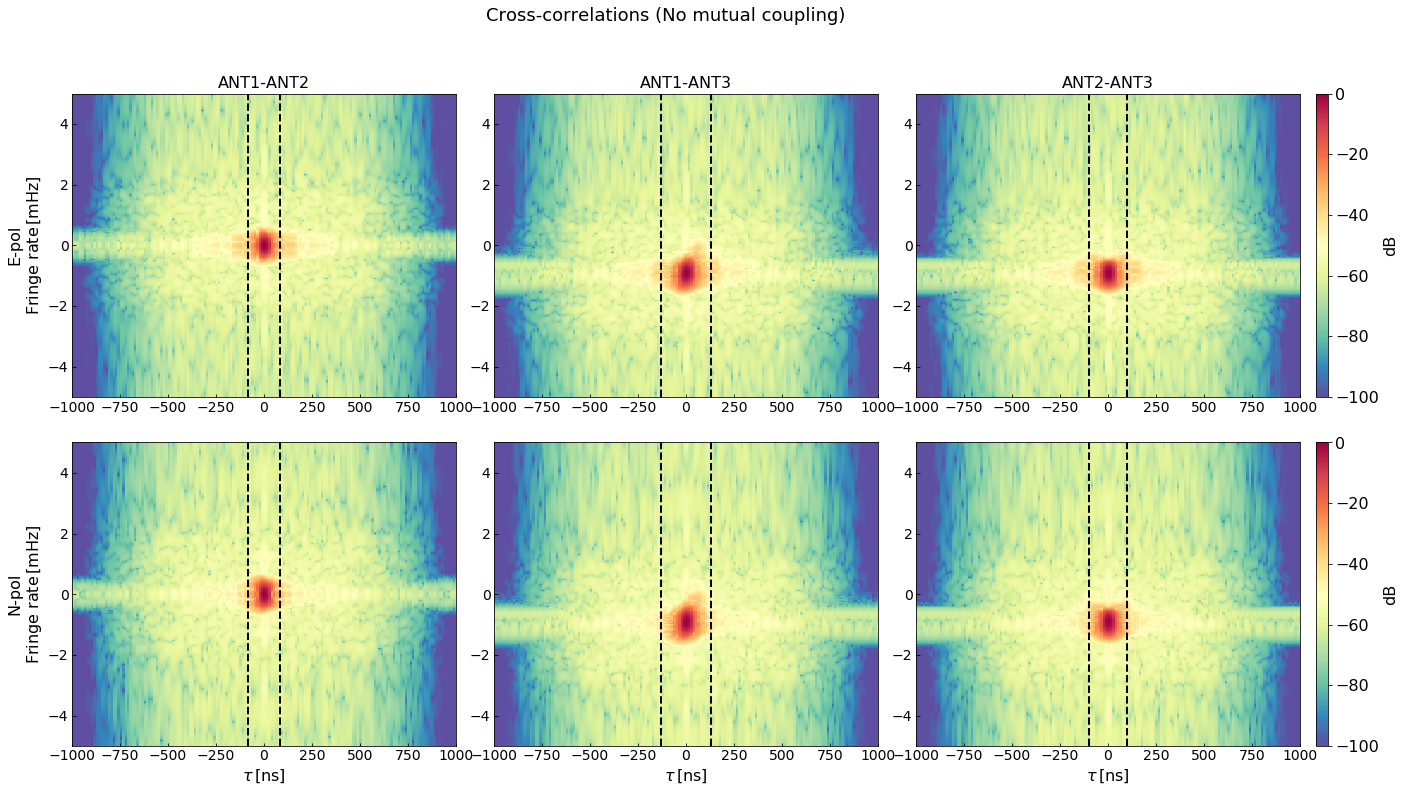

In [17]:
tf_g, ft_g = np.meshgrid(tau*1.e9,ft)
delayrate_spec_plotter(FF_cross_nocc,tf_g,ft_g,bls,cross_str,r'Cross-correlations (No mutual coupling)')

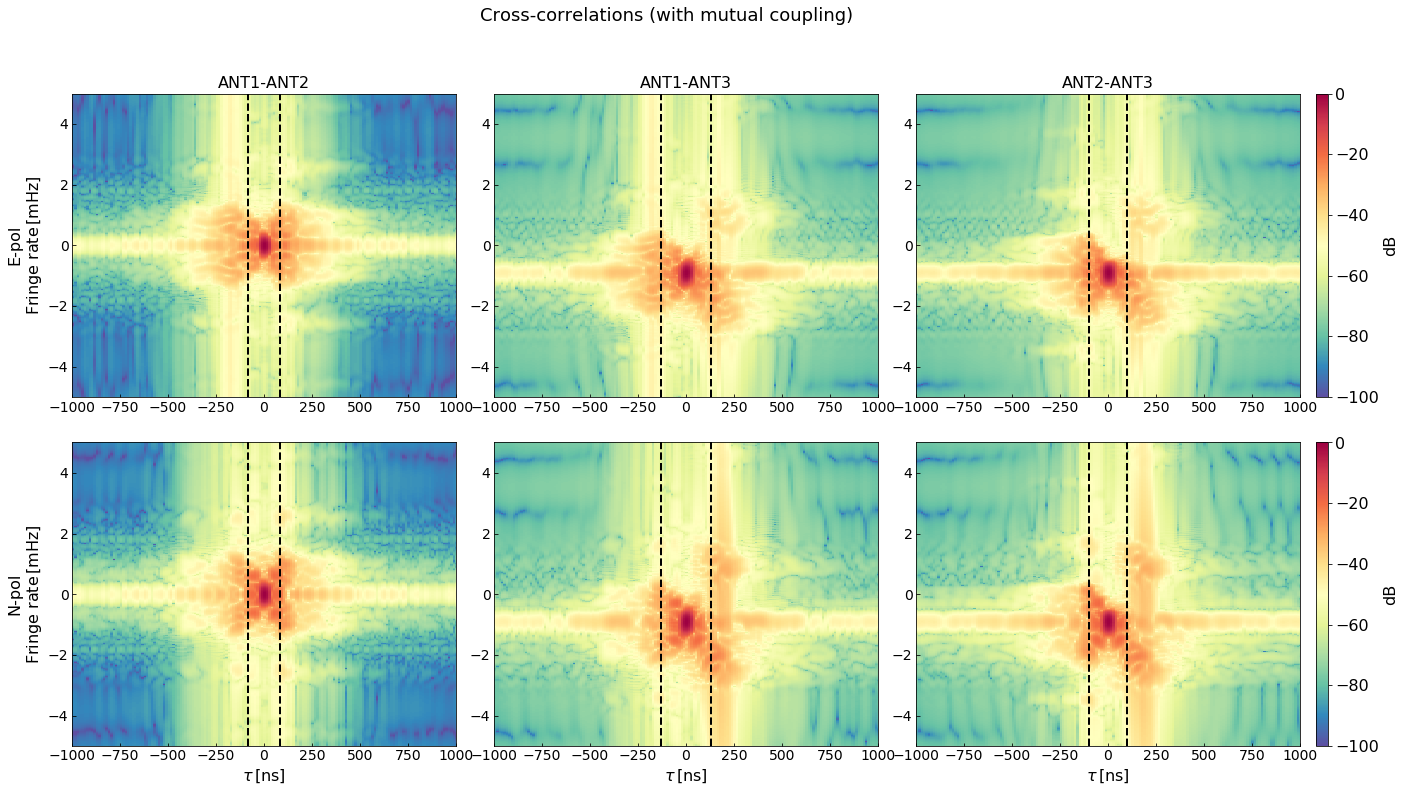

In [18]:
delayrate_spec_plotter(FF_cross_cc,tf_g,ft_g,bls,cross_str,r'Cross-correlations (with mutual coupling)')

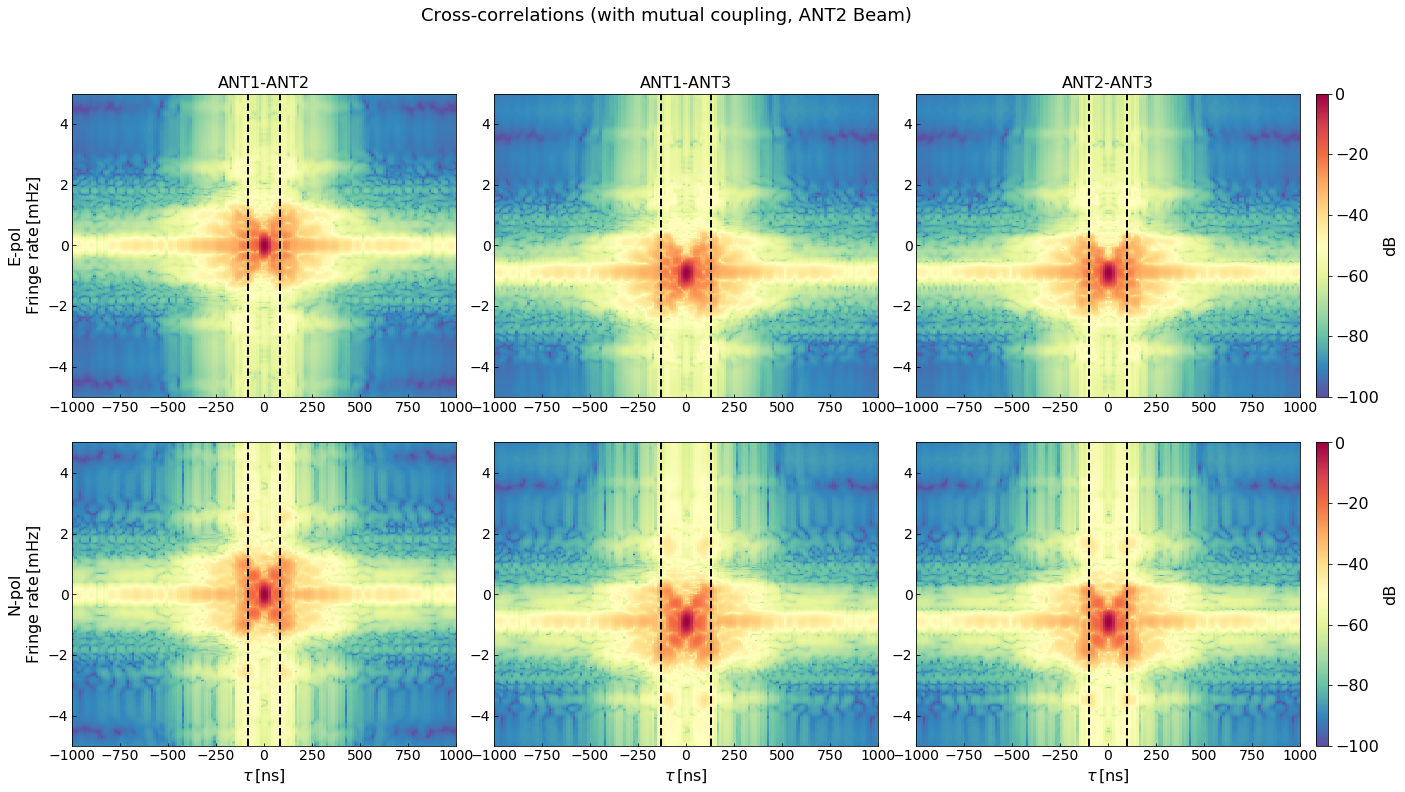

In [19]:
delayrate_spec_plotter(FF_cross_cc_1b,tf_g,ft_g,bls,cross_str,r'Cross-correlations (with mutual coupling, ANT2 Beam)')